# Problem 8 (20 Points)

## Problem Description

Several molecular dynamics simulations have been carried out for a material, and the phase (solid/liquid/vapor) at different temperature/pressure combinations has been recorded.

You will use gradient descent to train a One-vs-Rest logistic regression model on data with 3 classes. Fill out the notebook as instructed, making the requested plots and printing necessary values. 

*You are welcome to use any of the code provided in the previous problems.*

#### Summary of deliverables:
- 3 binomial classification `w` vectors, corresponding to each class
- Function `classify(xy)` that evaluates all 3 models at a given array of points, returning the class prediction as the model with the highest probability
- Print model percent classification accuracy on the training data
- Print model percent classification accuracy on the testing data
- Plot that shows the training data as data points, along with the class of a grid of points in the background, as in the lecture activity.

### Imports and Utility Functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_data(x, y, c,title="Phase of simulated material"):
    xlim = [0,52.5]
    ylim = [0,1.05]
    markers = [dict(marker="o", color="royalblue"), dict(marker="s", color="crimson"), dict(marker="^", color="limegreen")]
    labels = ["Solid", "Liquid", "Vapor"]

    plt.figure(dpi=150)

    for i in range(1+max(c)):
        plt.scatter(x[c==i], y[c==i], s=60, **(markers[i]), edgecolor="black", linewidths=0.4,label=labels[i])

    plt.title(title)
    plt.legend(loc="upper right")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Temperature, K")
    plt.ylabel("Pressure, atm")
    plt.box(True)

def plot_colors(classify, res=40):
    xlim = [0,52.5]
    ylim = [0,1.05]
    xvals = np.linspace(*xlim,res)
    yvals = np.linspace(*ylim,res)
    x,y = np.meshgrid(xvals,yvals)
    XY = np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)

    color = classify(XY).reshape(res,res)

    cmap = ListedColormap(["lightblue","lightcoral","palegreen"])
    plt.pcolor(x, y, color, shading="nearest", zorder=-1, cmap=cmap,vmin=0,vmax=2)
    return

## Load Data
This cell loads the dataset into the following variables:
- `train_data`: Nx2 array of input features, used for training
- `train_gt`: Array of ground-truth classes for each point in `train_data`
- `test_data`: Nx2 array of input features, used for testing
- `test_gt`: Array of ground-truth classes for each point in `test_data`

In the class arrays, 0 = solid, 1 = liquid, 2 = vapor.

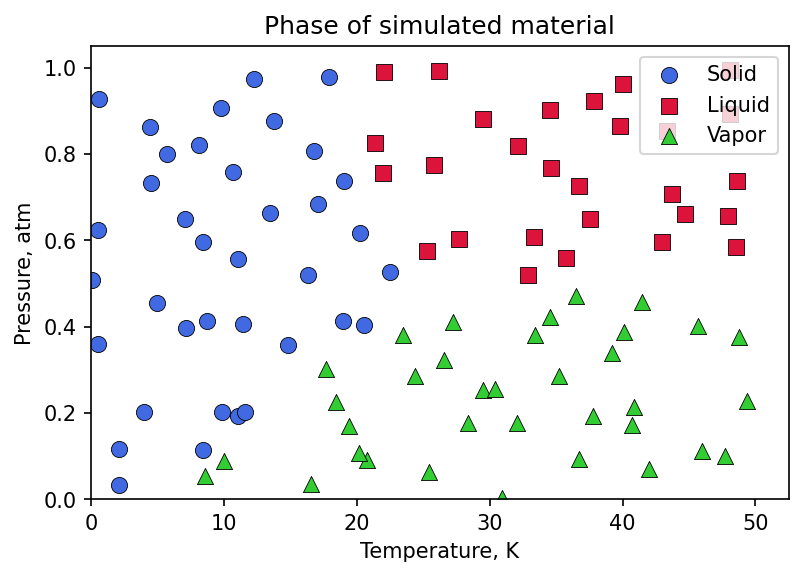

In [2]:
train = np.load("data/w3-hw2-data-train.npy")
test = np.load("data/w3-hw2-data-test.npy")
train_data, train_gt = train[:,:2], train[:,2].astype(int)
test_data, test_gt = test[:,:2], test[:,2].astype(int)
plot_data(train_data[:,0], train_data[:,1],train_gt)

## Gradient Descent

Here, write all of the necessary code to perform gradient descent and train 3 logistic regression models for a 1-vs-rest scenario. Use linear decision boundaries (features should only be 1, temperature, pressure)


Feel free to reuse code from the first problem or lecture activities.

We have provided the following function to help with the one-vs-all method:  

`convert_to_binary_dataset(classes, A)`:
- Input: data, Nx2 array of temperature-pressure data
- Input: classes, array (size N) of class values for each point in `data`
- Input: A, the class (0, 1, or 2 here) to use as '1' in the binary dataset
- Returns: `classes_binary`, copy of classes where class A is 1, and all other classes are 0.



In [3]:
def convert_to_binary_dataset(classes, A):
    classes_binary = (classes == A).astype(int)
    return classes_binary

In [4]:
# YOUR CODE GOES HERE (gradient descent and related functions)

def sigmoid(h):
    # YOUR CODE GOES HERE
    # input h is a scalar
    return 1/(1+np.exp(-h))

def transform(data, w):
    xs = data[:,0]
    ys = data[:,1]
    ones = np.ones_like(xs)
    h = w[0]*ones + w[1]*xs + w[2]*ys # element wise product, return (90, )
    return h # scalars -> ndarray

def loss(data, y, w):
    wt_x = transform(data,w)
    J1 = -np.log(sigmoid(wt_x)) * y # two classes classification 
    J2 = -np.log(1-sigmoid(wt_x)) * (1-y)
    L = np.sum(J1 + J2)
    return L



def grad_loss(data, y, w):
    wt_x  = transform(data, w)
    xs = data[:,0]
    ys = data[:,1]
    ones = np.ones_like(xs)
    # Calculate grad loss
    diff = sigmoid(wt_x) - y 
    # loss * xj -> (3,)
    loss = np.array([sum(diff * ones), sum(diff * xs), sum(diff*ys)]) 
    return loss # (3, )



# Training
Train your 3 models and print the `w` vector corresponding to each class

In [5]:
# YOUR CODE GOES HERE (training)
def grad_decent(data, label, w0 = np.array([0,0,0]), iteration = 50000, lr=0.0005):
    w = w0
    for _ in range(iteration):
        w = w - lr*grad_loss(data, label, w)  
  
    return w 


# YOUR CODE GOES HERE (print "w"s)
classes = [0,1,2]
# Store binary data classes
class_store = np.zeros((train_data.shape[0], len(classes)))

for A in classes:
    class_store[:,A] = convert_to_binary_dataset(train[:,-1], A)

# print weights
w = []
for c in range(class_store.shape[1]):
    w_i = grad_decent(train_data, class_store[:,c])
    w.append(w_i)
    print(w_i)


[ 5.1195343  -0.41852299  5.06600505]
[-21.82275999   0.36083033  19.07601096]
[  0.67922291   0.32086032 -25.39008467]


## Classification function
Write a function `classify(xy)` that will evaluate each model and select the appropriate class.


In [6]:

def classify(xy):
    # YOUR CODE GOES HERE
    results = []
    for model in w:
        prediction = sigmoid(transform(xy, model)) # return probability (num_data, 1)
        print(prediction.shape)
        # store probability of class A vs rest 
        results.append(prediction)
    results = np.array(results)
    # print(result)
    classes = np.argmax(results, axis = 0) # return class where maximum prob
    return classes
    


## Accuracy
Compute and print the accuracy on the training and testing sets as a percent

In [7]:
# YOUR CODE GOES HERE (accuracy)
def accuracy(data, y):
    preds = classify(data)
    acc = np.sum(preds == y) / len(y) * 100
    print("True Classes: ", y.astype(int))
    print(" Predictions: ", preds)
    return acc

acc_train = accuracy(train_data, train_gt)
print("Accuracy on traing data: %f %%" % acc_train)

acc_test = accuracy(test_data, test_gt)
print("Accuracy on testing data: %f %%" % acc_test)

(100,)
(100,)
(100,)
True Classes:  [0 2 2 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2
 2 2 2 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1]
 Predictions:  [0 2 2 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 0 2 2 2
 2 2 2 0 0 0 0 0 2 2 2 2 2 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1]
Accuracy on traing data: 98.000000 %
(25,)
(25,)
(25,)
True Classes:  [2 2 2 2 2 0 0 2 2 2 0 0 1 2 1 0 0 1 1 1 0 1 1 1 1]
 Predictions:  [2 2 2 2 2 0 0 2 2 2 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1]
Accuracy on testing data: 96.000000 %


## Plot results
Run this cell to visualize the data along with the results of `classify()`

(1600,)
(1600,)
(1600,)


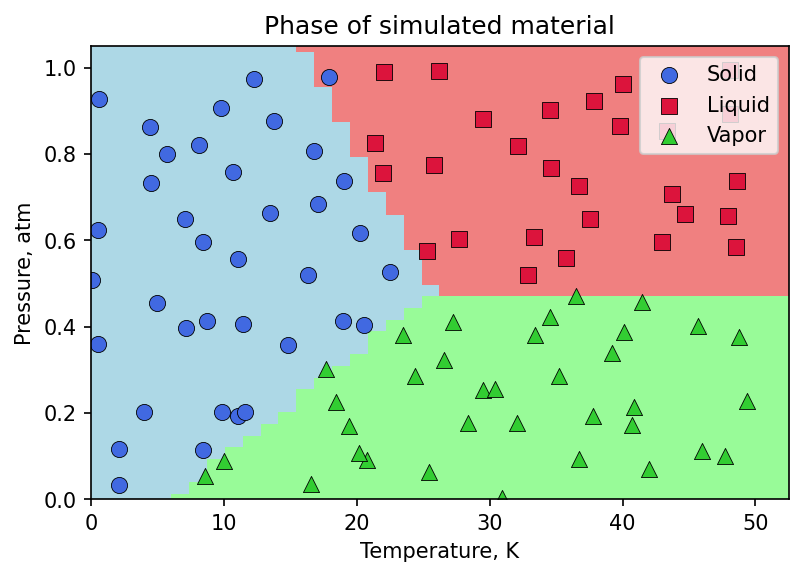

In [8]:
plot_data(train_data[:,0], train_data[:,1], train_gt)
plot_colors(classify)